<a href="https://colab.research.google.com/github/antoniotre86/IERCT/blob/master/notebooks/Causal_Inference_with_dowhy_simulated_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: Causal Inference with DoWhy - Simulated Data

We simulate two scenarios based on the exercise / cholesterol example. 

* In **Scenario 1** we make *exercise* have a causal effect on *cholesterol*;
* in **Scenario 2** *exercise* does not have a causal effect on *cholesterol*.

We introduce a couple of confounding factors to make things interesting. We assume that these are the only confounding factors at play:
* *occupation* ("stormtrooper" or "radar technician")
* *age* in decades
* *healthy diet*: binary, which depends on *Occupation*

In both scenarios *exercise* and *cholesterol* are influenced by *age*, while *exercise* is influenced by *occupation* and *cholesterol* is influenced by *healthy diet* (and indirectly by *occupation* through it). 

We will see how *exercise* and *cholesterol* appear correlated in both scenarios, and with statistical significance. But using propensity score stratification we will be able to uncover the true causal effects. 

We will also apply the refutation methods to validate our results. 

---

**Inference steps**:
1. Define the causal graphical model
2. Initialise the dowhy model by passing the training data and the graphical model in string dot format
3. Run `.identify_estimand` for the dowhy model to identify the possible methods of inference (we will use "backdoor.propensity_score_stratification")
4. Run `.estimate` to obtain the estimated causal effect
5. Refute estimate by running built-in refutation methods.

--- 

We are going to use [dowhy](https://github.com/microsoft/dowhy) which takes as input:
- training data
- causal graphical model (dot format)

---


Install the required dependencies

In [ ]:
!pip install dowhy
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
from graphviz import Source
from scipy.stats import ttest_ind

print(pd.__version__)
print(np.__version__)
print(dowhy.__version__)

1.1.5
1.19.5
0.6


In [ ]:
pd.set_option("precision", 3)

In [ ]:
# This prevents sklearn from printing a lot of warnings (copied from dowhy example notebooks)
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

## Define the graphical model

One option is to define it as a string in dot format (really an option for small graphs only).

Another option is to use [dagitty.net](http://www.dagitty.net/dags.html) -- allows you to create complex graphs by point-and-click. You can then export the textual version of it, which can be converted to dot fairly easily.

We go for the first option here as the graph is simple enough.

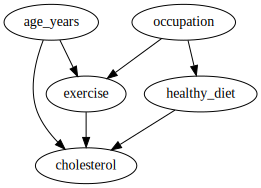

In [ ]:
graph_s = """
digraph {
  exercise;
  cholesterol;
  age_years;
  occupation;
  healthy_diet;
  age_years -> exercise;
  age_years -> cholesterol;
  occupation -> exercise;
  occupation -> healthy_diet;
  healthy_diet -> cholesterol;
  exercise -> cholesterol;
}
"""

dag = Source(graph_s)

dag

# Scenario 1: Exercise has a causal effect on Cholesterol level

## Generate the data

We randomly generate *occupation* and *age_years* first as they don't depend on other variables. 

We then generate *exercise* based on *occupation* and *age* assuming that:
- stormtroopers exercise more than radar technicians
- people under 40 exercise more than people aged 40 or older

We generate the *healty_diet* variable based on *occupation*, assuming radar technicians have a better diet.

Finally, we generate *cholesterol* levels assuming that:
- it's lower with an *healthy diet* and *exercise*
- it's lower for people less than 40 years of *age*.

In [ ]:
np.random.seed(333)

N = 1000

data_s1 = pd.DataFrame(columns=["exercise", "cholesterol", "occupation", "age_years", "healthy_diet"])

data_s1["occupation"] = np.random.choice(["stormtrooper", "radar_technician"], N)
data_s1["age_years"] = (np.random.normal(40, 10, N) / 10).astype(int) * 10

# Stormtroopers get more exercise
data_s1["exercise"] = np.random.randn(N) \
  + 1*(data_s1["occupation"] == "stormtrooper") \
  + -1*(data_s1["occupation"] == "radar_technician")
# People under 40 get more exercise
data_s1["exercise"] += 1*(data_s1["age_years"] < 40)
data_s1["exercise"] = (data_s1["exercise"] > data_s1["exercise"].mean())


# Stormtroopers have a poorer diet
data_s1["healthy_diet"] = np.random.rand(N) < (0.1*(data_s1["occupation"] == "stormtrooper") 
                                              + 0.9*(data_s1["occupation"] == "radar_technician"))

# Base level of cholesterol (random)
data_s1["cholesterol"] = 5 + np.random.randn(N)**2 

# A healthy diet gives lower cholesterol
data_s1["cholesterol"] += -3*data_s1["healthy_diet"] 

# People under 40 have lower cholesterol
data_s1["cholesterol"] += -1*(data_s1["age_years"] < 40)

# Exercise has the effect of reducing cholesterol
actual_effect_s1 = -1
data_s1["cholesterol"] += actual_effect_s1*data_s1["exercise"]

In [ ]:
data_s1

,exercise,cholesterol,occupation,age_years,healthy_diet
0,True,4.001,stormtrooper,40,False
1,False,5.100,stormtrooper,50,False
2,False,4.372,radar_technician,50,True
3,False,2.036,radar_technician,40,True
4,False,3.107,radar_technician,40,True
...,...,...,...,...,...
995,False,1.039,radar_technician,20,True
996,True,4.005,stormtrooper,50,False
997,True,4.012,stormtrooper,40,False
998,False,2.009,radar_technician,50,True


## Let's look at correlations first

Between *occupation*, *exercise* and *cholesterol*:

In [ ]:
data_s1.groupby(["occupation", "exercise"])["cholesterol"].mean().unstack(1)

exercise,False,True
occupation,,
radar_technician,2.812,1.525
stormtrooper,5.468,4.163


As expected, *cholesterol* is the highest for stormtroopers who don't exercise, and the lowest for radar technicians who exercise.

Let's add *age* as well:

In [ ]:
data_s1.groupby(["age_years", "occupation", "exercise"])["cholesterol"].mean().unstack([1,2])


occupation radar_technician        stormtrooper       
exercise              False  True         False  True 
age_years                                             
10                    2.175  2.909        1.089  4.646
20                    2.155  1.053        4.622  4.268
30                    2.250  1.471        5.181  3.588
40                    3.186  1.958        5.690  4.714
50                    3.320  2.098        5.477  4.434
60                    2.976  2.498        6.426  4.902
70                      NaN    NaN        5.003  4.504

For most age levels, cholesterol is lower when they exercise, and in general it's also lower for radar technicians.

Now we calculate the overall correlation coefficients:

In [ ]:
data_s1.corr()

,exercise,cholesterol,age_years,healthy_diet
exercise,1.000,0.110,-0.184,-0.514
cholesterol,0.110,1.000,0.196,-0.634
age_years,-0.184,0.196,1.000,0.052
healthy_diet,-0.514,-0.634,0.052,1.000


Most of these are expected, considering on how we generated the data. 

However, the correlation between cholesterol and exercise stands out. It looks like there is a POSITIVE correlation, meaning the more one exercise the higher their cholesterol levels!

In [ ]:
data_s1.corr().loc["cholesterol", "exercise"].round(3)

In [ ]:
data_s1.groupby("exercise")["cholesterol"].mean()

exercise
False    3.256
True     3.692
Name: cholesterol, dtype: float64

In [ ]:
observed_effect_s1 = data_s1.groupby("exercise")["cholesterol"].mean().diff().loc[True]
observed_effect_s1.round(3)

This appears to be an example of the [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox)

> *Simpson's paradox, which also goes by several other names, is a phenomenon in probability and statistics in which a trend appears in several groups of data but disappears or reverses when the groups are combined.*

In our example, cholesterol is lower for people who exercise if we break down the data by occupation and age, but it appears to be positively correlated with exercise if we look at the data in aggregate.

In [ ]:
ttest_ind(data_s1.loc[data_s1["exercise"], "cholesterol"].values, data_s1.loc[~data_s1["exercise"], "cholesterol"].values)

Ttest_indResult(statistic=3.494949741636341, pvalue=0.0004949873998274109)

A t-test confirms that the correlation is also statistically significant with p-value < 0.001.

## Causal Inference

We now turn to Causal Inference to hopefully find the true causal effect between exercise and cholesterol. 

We are going to use [dowhy]() for the task, and use [Propensity Score Matching](https://en.wikipedia.org/wiki/Propensity_score_matching) (with stratification) to estimate the actual causal effect. 

***

We first instantiate the model and pass our data, the treatment and outcome names, and the graph in dot format.


In [ ]:
model = CausalModel(
        data=data_s1,
        treatment="exercise",
        outcome="cholesterol",
        graph=graph_s.replace('\n', '').strip()
    )

Next, we run the actual estimation method.

`.identify_effect` parses the graph and defines the estimands.

`.estimate_effect` with "backdoor.propensity_score_stratification" as `method_name` runs the propensity score model and returns the estimated effect.

Here we can also define 
- specific method parameters in `method_params`; for PS stratification we can define the number of strata and how many items of one class required in each stratum as a minumum (otherwise the stratum is dropped);
- whether we want a confidence interval around the estimate, and the method to compute it; in this case we decided to calculate it with bootstrapping;
- whether we want to test for statistical significance (not recommended if you are calculating the confidence interval already as it will just slow down the estimation -- we can judge significance at the 95% level from the confidence interval already). 

In [ ]:
# Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the target estimand using a statistical method. Propensity score stratification.
estimate = model.estimate_effect(identified_estimand,
                                  method_name="backdoor.propensity_score_stratification",
                                  target_units="ate",
                                  test_significance=False,
                                  confidence_intervals='bootstrap',
                                  method_params={"num_strata":50, "clipping_threshold":5, "num_simulations":100})

estimated_effect_s1 = estimate.value
estimated_effect_c1_s1 = estimate.get_confidence_intervals()

print(f"Estimated causal effect: {estimated_effect_s1:0.3g}; "
  f"95% conf. int.: ({estimated_effect_c1_s1[0]:0.3g}, {estimated_effect_c1_s1[1]:0.3g})")
print(f"Actual causal effect: {actual_effect_s1}")

Estimated causal effect: -0.901; 95% conf. int.: (-1.15, -0.746)
Actual causal effect: -1


The estimated causal effect is correclty negative and close to the actual effect we defined when simulating the data (it's contained in the estimate confidence interval). 

What we would have thought being a positive relationship between exercise and cholesterol (more exercise - higher cholesterol), is in reality a negative one; the positive correlation we had observed was entirely due to the effect of the confounding factors. 

## Refutation

We will now see if we can refute the estimates (even though it's not necessary in this case as we have generated the data ourselves based on a pre-defined causal model).

Dowhy provides a collection of refutation methods to use. We will use three of them:
- adding a random confounder
- replacing treatment with a placebo
- re-running the estimate on data subsets

In [ ]:
np.random.seed(42)

refute_results_0 = model.refute_estimate(identified_estimand, 
                                          estimate, 
                                          method_name="random_common_cause", 
                                          confounders_effect_on_treatment="binary_flip", 
                                          confounders_effect_on_outcome="binary_flip")
print(refute_results_0)

Refute: Add a Random Common Cause
Estimated effect:-0.9011023663169796
New effect:-0.6404719954180753



In [ ]:
np.random.seed(42)

refute_results_1 = model.refute_estimate(identified_estimand, 
                                         estimate, 
                                         method_name="placebo_treatment_refuter", 
                                         placebo_type="Random Data", 
                                         num_simulations=10)

print(refute_results_1)

Refute: Use a Placebo Treatment
Estimated effect:-0.9011023663169796
New effect:0.0012099992118265624
p value:0.4955256903508029



In [ ]:
np.random.seed(42)

refute_results_2 = model.refute_estimate(identified_estimand, 
                                         estimate, 
                                         method_name="data_subset_refuter", 
                                         subset_fraction=0.5, 
                                         num_simulations=10)

print(refute_results_2)

Refute: Use a subset of data
Estimated effect:-0.9011023663169796
New effect:-0.8670165471484579
p value:0.4176858905993788



The three refutation methods used return the expected results:
- adding a randomly drawn confounder does not significantly change the estimate
- replacing the treatment with a randomly shuffled one makes the effect go to zero
- re-running the estimates on several subsamples of the data returns a similar estimate as the original one.

# Scenario 2: Exercise does not have an impact on Cholesterol level

Let's now see what happens if we generate the data such that there is no direct causal effect between exercise and cholesterol.

In [ ]:
np.random.seed(333)

N = 1000

data_s2 = pd.DataFrame(columns=["exercise", "cholesterol", "occupation", "age_years", "healthy_diet"])

data_s2["occupation"] = np.random.choice(["stormtrooper", "radar_technician"], N)
data_s2["age_years"] = (np.random.normal(40, 10, N) / 10).astype(int) * 10

# Stormtroopers get more exercise
data_s2["exercise"] = np.random.randn(N) \
  + 1*(data_s2["occupation"] == "stormtrooper") \
  + -1*(data_s2["occupation"] == "radar_technician")
# People under 40 get more exercise
data_s2["exercise"] += 1*(data_s2["age_years"] < 40)
data_s2["exercise"] = (data_s2["exercise"] > data_s2["exercise"].mean())

# Stormtroopers have a poorer diet
data_s2["healthy_diet"] = np.random.rand(N) < (0.1*(data_s2["occupation"] == "stormtrooper") 
                                              + 0.9*(data_s2["occupation"] == "radar_technician"))

# Base level of cholesterol (random)
data_s2["cholesterol"] = 5 + np.random.randn(N)**2 

# A healthy diet gives lower cholesterol
data_s2["cholesterol"] += -3*data_s2["healthy_diet"] 

# People under 40 have lower cholesterol
data_s2["cholesterol"] += -1*(data_s2["age_years"] < 40)

# Exercise has the effect of reducing cholesterol
actual_effect_s2 = 0.0
data_s2["cholesterol"] += actual_effect_s2*data_s2["exercise"]

## Let's look at correlations first

Between *occupation*, *exercise* and *cholesterol*:

In [ ]:
data_s2.groupby(["occupation", "exercise"])["cholesterol"].mean().unstack(1)

exercise,False,True
occupation,,
radar_technician,2.812,2.525
stormtrooper,5.468,5.163


Like before, *cholesterol* is the highest for stormtroopers who don't exercise, and the lowest for radar technicians who exercise.

Let's add *age* as well:

In [ ]:
data_s2.groupby(["age_years", "occupation", "exercise"])["cholesterol"].mean().unstack([1,2])


occupation radar_technician        stormtrooper       
exercise              False  True         False  True 
age_years                                             
10                    2.175  3.909        1.089  5.646
20                    2.155  2.053        4.622  5.268
30                    2.250  2.471        5.181  4.588
40                    3.186  2.958        5.690  5.714
50                    3.320  3.098        5.477  5.434
60                    2.976  3.498        6.426  5.902
70                      NaN    NaN        5.003  5.504

Cholesterol is still higher with older age, but now we don't see a correlation with exercise in the individual age groups.

Now we calculate the overall correlation coefficients:

In [ ]:
data_s2.corr()

,exercise,cholesterol,age_years,healthy_diet
exercise,1.000,0.343,-0.184,-0.514
cholesterol,0.343,1.000,0.141,-0.722
age_years,-0.184,0.141,1.000,0.052
healthy_diet,-0.514,-0.722,0.052,1.000


However, now cholesterol and exercise appear even more positively correlated!

In [ ]:
data_s2.corr().loc["cholesterol", "exercise"].round(3)

In [ ]:
data_s2.groupby("exercise")["cholesterol"].mean()

exercise
False    3.256
True     4.692
Name: cholesterol, dtype: float64

In [ ]:
observed_effect_s2 = data_s2.groupby("exercise")["cholesterol"].mean().diff().loc[True]
observed_effect_s2.round(3)

In [ ]:
ttest_ind(data_s2.loc[data_s2["exercise"], "cholesterol"].values, data_s2.loc[~data_s1["exercise"], "cholesterol"].values)

Ttest_indResult(statistic=11.522832599963817, pvalue=6.244220672354221e-29)

A t-test confirms that the correlation is also statistically significant with p-value < 0.001.

## Causal Inference

Let's use propensity score matching like before to see if it's able to estimate the real causal effect between exercise and cholesterol in this scenario (should be close to 0). 


In [ ]:
model = CausalModel(
        data=data_s2,
        treatment="exercise",
        outcome="cholesterol",
        graph=graph_s.replace('\n', '').strip()
    )

# Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate the target estimand using a statistical method. Propensity score stratification.
estimate = model.estimate_effect(identified_estimand,
                                  method_name="backdoor.propensity_score_stratification",
                                  target_units="ate",
                                  test_significance=False,
                                  confidence_intervals='bootstrap',
                                  method_params={"num_strata":100, "clipping_threshold":3, "num_simulations":100})

estimated_effect_s2 = estimate.value
estimated_effect_c1_s2 = estimate.get_confidence_intervals()

print(f"Estimated causal effect: {estimated_effect_s2:0.3g}; "
  f"95% conf. int.: ({estimated_effect_c1_s2[0]:0.3g}, {estimated_effect_c1_s2[1]:0.3g})")
print(f"Actual causal effect: {actual_effect_s2}")

Estimated causal effect: 0.0373; 95% conf. int.: (-0.235, 0.209)
Actual causal effect: 0.0


Indeed, the estimated causal effect is correclty close to zero (confirmed also by the confidence interval including zero).

Again, what we would have thought being a positive relationship between exercise and cholesterol (and this time even a stronger one than in the first scenario), does not exist in reality; the positive correlation we had observed was entirely due to the effect of the confounding factors. 